Lecture notes

- Tree: T
- Num of nodes: |T|
- terminal node, internal node

1. Regression Tree
- Find boxes R1...Rj minimizing RSS (RSS depends on the mean of Y in each box)
- Recursive binary splitting
    - Find Rj, Xi and s minimizing RSS
    - Only split one region at a time
    - Stopping criterion: num of observations in each region
    - This is a greedy method, as the best split is made at each step rather than leading to a better split in the future. (like forward feature selection)
- Tree pruning
    - Cost complexity pruning (weakest link pruning)
        - Use recursive binary splitting to grow a large tree T0
        - Find the subtree T minimizing RSS+Penalty, where Penaly = alpha * |T|
    - Use CV to determine the best tuning parameter alpha

2. Classification Tree
- algorithm is the same as regression tree
- instead of RSS, algorithm minimizes Gini index or Cross Entropy

3. Bagging
- A method to reduce the variance of the model
- Bootstrap creating B samples with replacement. For each sample, grow a large tree. 
- Use all trees to predict by taking the average (for regression) or majority vote (for classification)
- Out-of-bag (OOB) error estimation
    - One observation is only visible for 2/3 of the bagging (banefit from bootstrap). Use the left 1/3 trees to estimate the prediction error
    - For large B, OOB is equivalent to LOO CV
    - OOB to determine the best B
- Variable importance: record the total decrease of RSS or Gini index due to splits over a given predictor, then average over all B trees. Large value indicates important variable.

3. Random forests
- A random sample of m=sqrt(p) predictors is used for splitting in bagging
- Decorrelates trees by avoiding dominant predictor in the top split
- Tuning parameters:
    - tree num B
    - predictor num m

4. Boosting
- Trees are grown sequentially, i.e., each tree is grown using info from previous trees, and with modified response Y
- Learn slowly: improve the model in areas where it does not perform well
- Tuning parameters:
    - The number of tree B (use CV)
    - The shrinkage parameter lambda (0.01 or 0.001)
    - The num of splits d (1 works well)


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets,preprocessing
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn import metrics
from sklearn.utils import resample
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import BaggingRegressor, BaggingRegressor,RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier

import graphviz
import math
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrices, dmatrix

import os


%matplotlib inline

In [50]:
# Classification tree
data = pd.read_csv('data/Carseats.csv').dropna()
data['High'] = data.Sales.map(lambda x: 1 if x>8 else 0)
data.ShelveLoc = pd.factorize(data.ShelveLoc)[0]
data.Urban = data.Urban.map({'No':0, 'Yes':1})
data.US = data.US.map({'No':0, 'Yes':1})
data.head()

X = data.drop(['Sales', 'High'], axis = 1)
y = data.High
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 0)


ctree = DecisionTreeClassifier(max_depth=6).fit(X_train,y_train)
ctree.score(X_train,y_train)
print(confusion_matrix(y_test,ctree.predict(X_test)))

# plot tree
export_graphviz(ctree,out_file = "carseat_tree.dot",feature_names = X_train.columns)
with open("carseat_tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)
# os.remove("carseat_tree.dot")

[[36  7]
 [15 22]]


35.4062158288
{'max_depth': 3} 35.6386192265


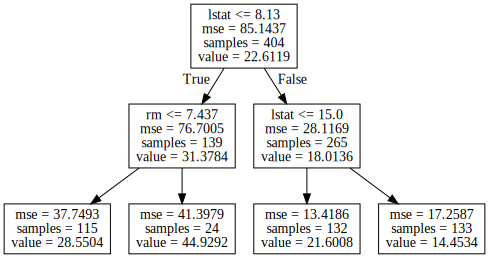

In [2]:
# Regression tree
df = pd.read_csv('data/Boston.csv')
X = df.drop('medv', axis = 1)
y = df.medv
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 0)

rtree = DecisionTreeRegressor(max_depth = 2).fit(X_train,y_train)
print(mean_squared_error(y_test,rtree.predict(X_test)))

# GridSearchCV to determine the best depth
d = np.arange(1,10) 
est = GridSearchCV(DecisionTreeRegressor(),dict(max_depth = d),cv=5,scoring="neg_mean_squared_error")
est.fit(X,y)
print(est.best_params_, -est.best_score_)

# plot tree
export_graphviz(rtree,out_file = "Boston_tree.dot",feature_names = X_train.columns)
with open("Boston_tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)
# os.remove("Boston_tree.dot")

In [3]:
# Bagging - regression
bagging_rtree = BaggingRegressor(oob_score=True).fit(X_train,y_train)
print(mean_squared_error(y_test,bagging_rtree.predict(X_test)))
print(bagging_rtree.oob_score_)

# GridSearchCV to determine the best num B
d = np.arange(1,20) 
est = GridSearchCV(BaggingRegressor(),dict(n_estimators = d),cv=5,scoring="neg_mean_squared_error")
est.fit(X,y)
print(est.best_params_, -est.best_score_)


25.8318941176
0.810763211504
{'n_estimators': 19} 20.9547961306


/Users/lhd0430/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:723: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


23.7974343137
0.746094726808
{'max_features': 9, 'n_estimators': 10} 18.6334664032


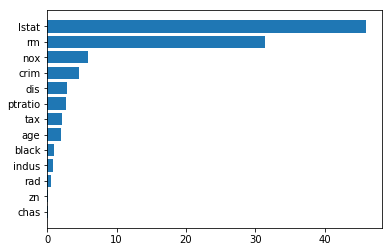

In [4]:
# Random forests - regression
# if m=p then this is equivalent to bagging above
rand_rtree = RandomForestRegressor(max_features=6, random_state=1,oob_score=True).fit(X_train,y_train)
print(mean_squared_error(y_test,rand_rtree.predict(X_test)))
print(rand_rtree.oob_score_)

# GridSearchCV to determine the best num of features and num B (can apply this to other tuning parameters)
m = np.arange(1,13) 
d = np.arange(10,12) 
est = GridSearchCV(RandomForestRegressor(),dict(max_features = m, n_estimators=d),cv=5,scoring="neg_mean_squared_error")
est.fit(X,y)
print(est.best_params_, -est.best_score_)

# Feature importance
fimp = pd.DataFrame({"Importance":rand_rtree.feature_importances_*100}, index=X.columns)
fig,ax = plt.subplots()
ax.barh(np.arange(1,14),width = fimp.sort_values(by="Importance").Importance,align='center')
ax.set_yticks(np.arange(1,14,1))
ax.set_yticklabels(fimp.sort_values(by="Importance").index)
plt.show()

49.9485452783
{'learning_rate': 0.10000000000000001} 18.4205859687


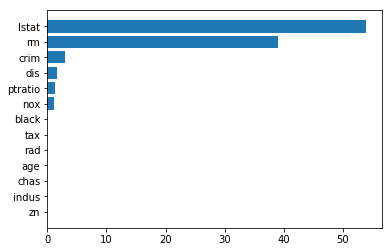

In [13]:
# Boosting
boost_rtree = GradientBoostingRegressor(n_estimators=500, learning_rate=0.001, max_depth=2).fit(X_train,y_train)
print(mean_squared_error(y_test,boost_rtree.predict(X_test)))

# GridSearchCV to determine the best learning rate (can apply this to other tuning parameters) 
r = np.arange(0.1,0.5) 
est = GridSearchCV(GradientBoostingRegressor(n_estimators=500, max_depth=2),dict(learning_rate=r),cv=5,scoring="neg_mean_squared_error")
est.fit(X,y)
print(est.best_params_, -est.best_score_)

# Feature importance
fimp = pd.DataFrame({"Importance":boost_rtree.feature_importances_*100}, index=X.columns)
fig,ax = plt.subplots()
ax.barh(np.arange(1,14),width = fimp.sort_values(by="Importance").Importance,align='center')
ax.set_yticks(np.arange(1,14,1))
ax.set_yticklabels(fimp.sort_values(by="Importance").index)
plt.show()